In [77]:
# Import python modules
import tensorflow 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras_tuner 
from google.cloud import aiplatform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import json, os

In [78]:
# Declare variables
REGION = "us-central1"
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
MODEL_PATH='gs://level300/model/'
DATASET_PATH='gs://level300/area_cover_dataset.csv'
PIPELINE_ROOT = 'gs://level300'
MODEL_ARTIFACTS_LOCATION ='gs://level300/artifact'
BUCKET_NAME="gs://level300/"

In [235]:
# Read the area_cover_dataset csv data into pandas dataframe
area_cover_dataframe = pd.read_csv(DATASET_PATH)


**Task 4** Create the function that converts categorical data to indexed integer values

In [11]:
area_cover_dataframe.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
       'Area_Cover'],
      dtype='object')

In [12]:
area_cover_dataframe.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Area_Cover
0,3142,183,9,648,101,757,223,247,157,1871,Commanche,C7757,1
1,2156,18,28,0,0,1207,187,170,107,960,Cache,C6102,3
2,1967,124,16,60,9,124,245,227,105,451,Cache,C2704,2
3,3237,305,15,663,19,3593,178,231,193,1260,Commanche,C7201,0
4,2981,221,18,150,14,4584,195,254,191,1822,Rawah,C7745,0


In [13]:
area_cover_dataframe.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Area_Cover
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2959.207290,155.392240,14.081810,268.669520,46.198330,2353.9479,212.174850,223.310280,142.503660,1979.001530,1.051480
std,280.355661,111.882118,7.469318,212.210338,57.730711,1560.1382,26.741464,19.758315,38.153698,1325.086691,1.396506
min,1859.000000,0.000000,0.000000,0.000000,-166.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.000000,58.000000,9.000000,108.000000,7.000000,1106.0000,198.000000,213.000000,119.000000,1022.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,29.000000,1998.0000,218.000000,226.000000,143.000000,1710.000000,1.000000
75%,3163.000000,260.000000,18.000000,384.000000,68.000000,3333.0000,231.000000,237.000000,168.000000,2549.000000,1.000000
max,3857.000000,360.000000,65.000000,1397.000000,601.000000,7078.0000,254.000000,254.000000,253.000000,7150.000000,6.000000


In [14]:
area_cover_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Elevation                           100000 non-null  int64 
 1   Aspect                              100000 non-null  int64 
 2   Slope                               100000 non-null  int64 
 3   Horizontal_Distance_To_Hydrology    100000 non-null  int64 
 4   Vertical_Distance_To_Hydrology      100000 non-null  int64 
 5   Horizontal_Distance_To_Roadways     100000 non-null  int64 
 6   Hillshade_9am                       100000 non-null  int64 
 7   Hillshade_Noon                      100000 non-null  int64 
 8   Hillshade_3pm                       100000 non-null  int64 
 9   Horizontal_Distance_To_Fire_Points  100000 non-null  int64 
 10  Wilderness_Area                     100000 non-null  object
 11  Soil_Type                           1000

In [15]:
area_cover_dataframe["Soil_Type"].unique()

array(['C7757', 'C6102', 'C2704', 'C7201', 'C7745', 'C7202', 'C7102',
       'C8772', 'C6731', 'C4703', 'C4744', 'C2702', 'C7746', 'C2703',
       'C7755', 'C4758', 'C7756', 'C8771', 'C8776', 'C7700', 'C6101',
       'C4704', 'C7702', 'C4201', 'C2717', 'C2705', 'C7709', 'C7790',
       'C5101', 'C7103', 'C7710', 'C7101', 'C3502', 'C8703', 'C2706',
       'C8708', 'C7701', 'C8707', 'C3501', 'C5151'], dtype=object)

In [16]:
wild_colums = pd.get_dummies(area_cover_dataframe["Wilderness_Area"])

In [17]:
backup_area_cover_dataframe = pd.read_csv(DATASET_PATH)

In [18]:
backup_area_cover_dataframe.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type',
       'Area_Cover'],
      dtype='object')

In [86]:
# Function that takes the area cover dataframe and converts the two categorical (string) columns into indexed values
def index(dataframe):
  wild_columns = pd.get_dummies(dataframe["Wilderness_Area"])
  soil_columns= pd.get_dummies(dataframe["Soil_Type"])
  dataframe.drop(['Wilderness_Area', 'Soil_Type'], axis=1, inplace=True)
  dataframe = pd.concat([dataframe, wild_columns, soil_columns], axis='columns')
  return dataframe

**Task 5** Extract the feature columns and standardize the values

In [88]:
# Extract the feature columns into a new dataframe called scaler_features that has been standardized using the sklearn.preprocessing.StandardScaler method.
# The features are all columns from the area cover dataset except the "Area_Cover" column
area_cover_dataframe = pd.read_csv(DATASET_PATH)
indexed_dataframe = index(area_cover_dataframe)
features_dataframe = indexed_dataframe.drop("Area_Cover", axis = 1)
standard_scaler = StandardScaler()

scaled_features = standard_scaler.fit_transform(features_dataframe)

In [89]:
#area_cover_dataframe = pd.read_csv(DATASET_PATH)

In [90]:
indexed_dataframe.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Area_Cover', 'Cache',
       'Commanche', 'Neota', 'Rawah', 'C2702', 'C2703', 'C2704', 'C2705',
       'C2706', 'C2717', 'C3501', 'C3502', 'C4201', 'C4703', 'C4704', 'C4744',
       'C4758', 'C5101', 'C5151', 'C6101', 'C6102', 'C6731', 'C7101', 'C7102',
       'C7103', 'C7201', 'C7202', 'C7700', 'C7701', 'C7702', 'C7709', 'C7710',
       'C7745', 'C7746', 'C7755', 'C7756', 'C7757', 'C7790', 'C8703', 'C8707',
       'C8708', 'C8771', 'C8772', 'C8776'],
      dtype='object')

In [93]:
indexed_dataframe.shape

(100000, 55)

In [94]:
len(area_cover_dataframe.columns)

11

In [96]:
# Create a binary matrix containing the categorical Area_Cover column data converted using keras.utils.to_categorical()
labels_dataframe = indexed_dataframe["Area_Cover"]
categorical_labels = to_categorical(labels_dataframe)

In [97]:
# Split the dataset into model training and validation data
dfx_train, dfx_val, dfy_train, dfy_val = train_test_split(scaled_features, categorical_labels, test_size=0.2)

**Task 6** Create a function that returns a sequential categorical model function with a hyperparameter tuning layer

In [98]:
import pickle

In [99]:
with open("dfx_train", "wb") as f:
    pickle.dump( dfx_train,f)
    
with open("dfx_val", "wb") as f:
    pickle.dump( dfx_val,f)
with open("dfy_train", "wb") as f:
    pickle.dump( dfy_train,f)
with open("dfy_val", "wb") as f:
    pickle.dump( dfy_val,f)

In [100]:
# Create a function that returns a sequential categorical model function with a hyperparameter tuning layer
def build_model(hptune):
    model = Sequential()
    model.add(Dense(32, input_shape = (dfx_train.shape[1],), activation = "relu"))
    hp_units = hptune.Int('units', min_value=32, max_value=512, step=32)
    hp_units_2 = hptune.Int('units_layer2', min_value=512, max_value=1024, step=32)
    model.add(keras.layers.Dense(units=hp_units_2, activation=hptune.Choice("activation",['relu','elu'])))
    model.add(keras.layers.Dropout(hptune.Choice("drop",[0.2,0.3,0.4,0.5])))
    model.add(keras.layers.Dense(7, activation='softmax'))
    
    hp_learning_rate = hptune.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    
    return model

**Task 7** Create a Keras Hyperband Hyperparameter tuner with an accuracy objective

In [101]:
# Create a Keras Hyperband Hyperparameter tuner with an accuracy objective

#tuner =  [ TODO - Insert your code ]
import keras_tuner as kt
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='demo_my_dir')

INFO:tensorflow:Reloading Oracle from existing project my_dir/demo_my_dir/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/demo_my_dir/tuner0.json


2022-03-24 00:35:04.214396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-03-24 00:35:04.214441: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-24 00:35:04.214466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vm-91647a6a-1d5b-4686-a7d5-3a015621db67): /proc/driver/nvidia/version does not exist
2022-03-24 00:35:04.214817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  

**Task 8** Perform Hyperparameter tuning and train the optimal model

You do not have to add any of your own code for this task. Run the cells to tune, optimize and train the model. 

In [102]:
# Define an early stopping callback using that stops when the validation loss quantity does not improve after 5 epochs
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform a Keras Tuner Search for the best hyperparameter configurations using the training data split over 50 epochs
tuner.search(dfx_train, dfy_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters for the model as determined from the search
best_hyperparameters=tuner.get_best_hyperparameters(num_trials=10)[0]

INFO:tensorflow:Oracle triggered exit


In [103]:
# Create a new model using the best_hyperparameters and train it. 
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(dfx_train, dfy_train, epochs=10, validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6720 - accuracy: 0.7140 - val_loss: 0.6107 - val_accuracy: 0.7322
Epoch 2/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5748 - accuracy: 0.7528 - val_loss: 0.5613 - val_accuracy: 0.7565
Epoch 3/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5392 - accuracy: 0.7665 - val_loss: 0.5236 - val_accuracy: 0.7714
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5106 - accuracy: 0.7790 - val_loss: 0.5054 - val_accuracy: 0.7798
Epoch 5/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4897 - accuracy: 0.7898 - val_loss: 0.4778 - val_accuracy: 0.7951
Epoch 6/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4714 - accuracy: 0.7972 - val_loss: 0.4600 - val_accuracy: 0.8041
Epoch 7/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4532 - accuracy: 0.8061 - val_loss: 0.4508 - val_accuracy:

In [105]:
best_hyperparameters.values

{'units': 288,
 'learning_rate': 0.001,
 'drop1': 0.3,
 'drop2': 0.2,
 'units_layer1': 192,
 'units_layer2': 864,
 'activation': 'relu',
 'drop': 0.2,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [106]:
# Using the model training history find and print out the epoch with the best validation accuracy. 
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 10


In [107]:
# Print out the Model test loss and test accuracy by evaluating the validation data split. 
eval_result = model.evaluate(dfx_val, dfy_val)
print("[Model test loss, test accuracy]:", eval_result)

625/625 [==============================] - 1s 1ms/step - loss: 0.4198 - accuracy: 0.8245
[Model test loss, test accuracy]: [0.41981932520866394, 0.8244500160217285]


In [108]:
# Create a new model (hypermodel) using the best_hyperparameters and retrain. 
hypermodel = tuner.hypermodel.build(best_hyperparameters)
# Retrain the model using the number of epochs that was previously determined to be the best. 
hypermodel.fit(dfx_train, dfy_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 5s 2ms/step - loss: 0.6696 - accuracy: 0.7161 - val_loss: 0.6108 - val_accuracy: 0.7323
Epoch 2/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5749 - accuracy: 0.7524 - val_loss: 0.5573 - val_accuracy: 0.7553
Epoch 3/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5326 - accuracy: 0.7689 - val_loss: 0.5157 - val_accuracy: 0.7739
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5042 - accuracy: 0.7822 - val_loss: 0.4921 - val_accuracy: 0.7868
Epoch 5/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4790 - accuracy: 0.7933 - val_loss: 0.4725 - val_accuracy: 0.7971
Epoch 6/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4591 - accuracy: 0.8040 - val_loss: 0.4625 - val_accuracy: 0.8046
Epoch 7/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4420 - accuracy: 0.8119 - val_loss: 0.4395 - val_accuracy:

In [111]:
# Print out the test loss and test accuracy for hypermodel by evaluating the validation data split. 
eval_result = hypermodel.evaluate(dfx_val, dfy_val)
print("[Hypermodel test loss, test accuracy]:", eval_result)

625/625 [==============================] - 1s 1ms/step - loss: 0.4127 - accuracy: 0.8224
[Hypermodel test loss, test accuracy]: [0.41267162561416626, 0.8223999738693237]


In [112]:
# Save the hypertuned model
# NB the MODEL_PATH bucket must be created before this will succeed and it must be in the same location as the model.
# e.g. gsutil mb -l us-central1  gs://${PROJECT_ID}-bucket
hypermodel.save(MODEL_PATH)

INFO:tensorflow:Assets written to: gs://level300/model/assets


**Task 9** Create a Custom Container for Vertex AI pipeline model training
1. Create a Python model trainer module using the above code
2. Save the code as `model.py` in the `model/trainer` beneath the current working directory for this notebook
3. Make sure you set the Project ID correctly in the Python script. 
4. Create the Dockerfile definition in the `model/` directory for your custom training container using the `gcr.io/deeplearning-platform-release/tf2-cpu.2-6` base container image

Once you have prepared the custom container Python module code and Dockerfile you can build and test the custom container. 

In [113]:
!mkdir trainer

mkdir: cannot create directory ‘trainer’: File exists


In [185]:
%%writefile task.py
import tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
#from google.cloud import aiplatform
import argparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import json, os

REGION = "us-central1"
PROJECT_ID = "demogct"
PROJECT_ID = PROJECT_ID[0]
MODEL_PATH=os.getenv("AIP_MODEL_DIR")
DATASET_PATH='gs://level300/area_cover_dataset.csv'
PIPELINE_ROOT = 'gs://level300'
MODEL_ARTIFACTS_LOCATION ='gs://level300/artifact'
BUCKET_NAME="gs://level300/"


parser = argparse.ArgumentParser()
parser.add_argument('--epochs', dest='epochs',
                    default=200, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()



## Build Dataframe
area_cover_dataframe = pd.read_csv(DATASET_PATH)
# Function that takes the area cover dataframe and converts the two categorical (string) columns into indexed values
def index(dataframe):
  wild_columns = pd.get_dummies(dataframe["Wilderness_Area"])
  Soil_Type= pd.get_dummies(dataframe["Soil_Type"])
  dataframe.drop(['Wilderness_Area', 'Soil_Type'], axis=1, inplace=True)
  dataframe = pd.concat([dataframe, wild_columns, Soil_Type], axis='columns')
  return dataframe

indexed_dataframe = index(area_cover_dataframe)
features_dataframe = indexed_dataframe.drop("Area_Cover", axis = 1)
standard_scaler = StandardScaler()

scaled_features = standard_scaler.fit_transform(features_dataframe)
labels_dataframe = indexed_dataframe["Area_Cover"]
categorical_labels = to_categorical(labels_dataframe)
dfx_train, dfx_val, dfy_train, dfy_val = train_test_split(scaled_features, categorical_labels, test_size=0.2)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR'])

### Build Model

model = Sequential()
model.add(Dense(32, input_shape = (dfx_train.shape[1],), activation = "relu"))
model.add(keras.layers.Dense(units=192, activation="relu"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units=864, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(7, activation='softmax'))
    
model.compile(optimizer=keras.optimizers.Adam(0.001),
                loss="categorical_crossentropy",   
                metrics=['accuracy'])

model.fit(dfx_train, dfy_train, epochs=197, validation_split=0.2)   

#Save Model
model.save(MODEL_PATH)

Overwriting task.py


In [269]:
import numpy as np
from datetime import datetime

import os
import sys

#Vertex SDK
from google.cloud import aiplatform
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

JOB_NAME = "exam_custom_job_" + TIMESTAMP
MODEL_DIR = "{}/{}".format(BUCKET_NAME, JOB_NAME)

MACHINE_TYPE = "n1-standard"

VCPU = "16"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 2)

DEPLOY_GPU, DEPLOY_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)


if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"

EPOCHS = 20
STEPS = 100
lr = 0.0001

CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--steps=" + str(STEPS),
    "--distribute=" + TRAIN_STRATEGY,
]


Train machine type n1-standard-16
Deploy machine type n1-standard-4


In [116]:
# Build the container using the following gcr.io tag
TRAIN_IMAGE="gcr.io/{}/tensorflow:latest".format(PROJECT_ID)
#!docker build ~/model/. -t $IMAGE_URI

In [117]:
# Run the docker image locally to test it
#!docker run $IMAGE_URI

In [118]:
# Push the docker image to the Google container registry
#!docker push $IMAGE_URI

https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-1.0.1/google_cloud_pipeline_components.aiplatform.html

In [187]:
#Pre-Built Containers
TRAIN_VERSION = "tf-gpu.2-1"
DEPLOY_VERSION = "tf2-gpu.2-1"

TRAIN_IMAGE = "gcr.io/cloud-aiplatform/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "gcr.io/cloud-aiplatform/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)


Training: gcr.io/cloud-aiplatform/training/tf-gpu.2-1:latest AcceleratorType.NVIDIA_TESLA_K80 2
Deployment: gcr.io/cloud-aiplatform/prediction/tf2-gpu.2-1:latest AcceleratorType.NVIDIA_TESLA_K80 1


In [ ]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["tensorflow_datasets==1.3.0", "pandas","gcsfs","google-cloud-storage","google-api-python-client","cloudml-hypertune"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

#Model Display name
MODEL_DISPLAY_NAME = "areacover-" + TIMESTAMP

# Start the training
if TRAIN_GPU:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
    )
else:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_count=0,
    )

In [ ]:
# Install kubeflow pipeline SDK and google cloud pipeline component for building Vertex AI pipelines
!pip3 install kfp google_cloud_pipeline_components --user

In [ ]:
 !pip3 install $USER kfp google-cloud-pipeline-components --upgrade

In [188]:
# Import the libraries required for Vertext AI pipelines
import kfp
from kfp.v2 import compiler
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from google.cloud.aiplatform import gapic as aip
EXPERIMENT_NAME="level300-area-service"
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

**Task 10** Define the Vertex AI Training pipeline

1. Add your code for the Training Operation using your newly created custom container
    * This should reference the custom container_uri passed in as a parameter
    * This should use "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest" for the `model_serving_container_image_uri`
2. Add your code for the Model Deploy Operation
    * This operation should output a model and an endpoint.
    
All machine types should be specified as "n1-standard-4"


In [189]:
BUCKET_NAME

'gs://level300/'

In [190]:
# Define the Vertex AI pipeline
pipeline_root_path = "gs://level300/PIPELINE_ROOT"
@kfp.dsl.pipeline(name="area-copverage-vertex-ai-pipeline",
                  pipeline_root=PIPELINE_ROOT)
def pipeline(
    bucket: str = MODEL_ARTIFACTS_LOCATION,
    project: str = PROJECT_ID,
    gcp_region: str = REGION,
    container_uri: str = "",
):
    
    training_op = gcc_aip.CustomContainerTrainingJobRunOp(
        project=project,
        display_name="area-copverage-vertex-ai-pipeline-training",
        container_uri=container_uri,
        machine_type="n1-standard-16",
        accelerator_type="NVIDIA_TESLA_V100",
        staging_bucket=bucket,
        accelerator_count="2",
        model_serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-6:latest",
        model_description="This is a area service model",
        #tensorboard="projects/demogct/locations/us-central1/tensorboards/8108607983778267136",
        #service_account="vertexuser@demogct.iam.gserviceaccount.com"
    )
       
    create_endpoint_op = gcc_aip.EndpointCreateOp(
        project=project,
        display_name = "area-copverage-vertex-ai-model-endpoint",
    )
    
    model_deploy_op = gcc_aip.ModelDeployOp(
        
        model=training_op.outputs["model"],
        endpoint=create_endpoint_op.outputs['endpoint'],
        dedicated_resources_machine_type="n1-standard-4",
        dedicated_resources_min_replica_count=1,
        dedicated_resources_max_replica_count=2
    )

In [191]:
# Compile the  Vertex AI pipeline
compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="area-copverage-vertex-ai-pipeline.json"
)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1266: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


**Task 11** Create the Vertex AI Pipeline job object

The pipeline job must specified using the compiled pipeline definition JSON file and should point to your saved model location and your custom training container

In [192]:
# Create the Vertex AI Pipeline job object
#aiplatform.start_run("custom-training-run-4")  # Change this to your desired run name
''' parameters = {"epochs": 200, 'units': 288,
 'learning_rate': 0.001,
 'drop1': 0.3,
 'drop2': 0.2,
 'units_layer1': 192,
 'units_layer2': 864,
 'activation': 'relu',
 'drop': 0.2,} '''


#aiplatform.log_params(parameters)

pipeline_job = aiplatform.PipelineJob(
    display_name="area-copverage-vertex-ai-pipeline-run",
    template_path="area-copverage-vertex-ai-pipeline.json",
    pipeline_root=pipeline_root_path, 
    location="us-central1",
    parameter_values={"bucket":"gs://level300/","project":"demogct","gcp_region":"us-central1", "container_uri":"gcr.io/demogct/areaservice:latest" },
    enable_caching=False
)

In [193]:
# Run the Vertex AI pipeline job
pipeline_job.run()

INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/313681173937/locations/us-central1/pipelineJobs/area-copverage-vertex-ai-pipeline-20220324091525
INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:
INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/313681173937/locations/us-central1/pipelineJobs/area-copverage-vertex-ai-pipeline-20220324091525')
INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/area-copverage-vertex-ai-pipeline-20220324091525?project=313681173937
INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/313681173937/locations/us-central1/pipelineJobs/area-copverage-vertex-ai-pipeline-20220324091525 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.pipeline_jobs:Pi

In [195]:
# List the model created by the pipeline
!gcloud ai models list --region=$REGION

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
4325447957345206272  area-copverage-vertex-ai-pipeline-training-model
1285518208870121472  area-copverage-vertex-ai-pipeline-training-model
1359264652768313344  area-coverage_20223235916
4259019862841491456  area-copverage-vertex-ai-pipeline-training-model
371287484513910784   area-copverage-vertex-ai-pipeline-training-model
5244182281328787456  area-copverage-vertex-ai-pipeline-training-model
5583641103241838592  area-copverage-vertex-ai-pipeline-training-model
6317727842503229440  area-copverage-vertex-ai-pipeline-training-model
6413992284538273792  areacover-20220323024049
3282583168632225792  v1647627416
2885703451470200832  train-automl-flowers
146336201563963392   levi-train-automl-flowers
5278715742533976064  Claims_fraud_2021121405417
7448606337996423168  cifar10-20211213165546
7272965952528973824  fraud_detection_20211211144118
8416880257881079808  beans-model-pipeline
50535357611

In [196]:
# Store the endpoint ID where the model has been deployed 

!gcloud ai endpoints list --region=$REGION
ENDPOINT_IDS=!gcloud ai endpoints list --region=$REGION --format="value(name)" 2>/dev/null
print("Vertex AI Endpoint ID:" + ENDPOINT_IDS[0])


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
265052671038193664   area-copverage-vertex-ai-model-endpoint
1850319739872608256  area-copverage-vertex-ai-model-endpoint
1011524309274853376  area-copverage-vertex-ai-model-endpoint
3167904105855188992  prediction-penguin-vertex-training
2527724455698890752  claims_fraud
3410429982663507968  bq_fraud_detection
5437049814980231168  beans-model-pipeline_endpoint
825363796552843264   beans-model-pipeline_endpoint
9128664503284662272  fraud_endpoint
4848837482399137792  churn
7438407268137172992  beans-model-pipeline_endpoint
2478818178495414272  beans-model-pipeline_endpoint
6641270134092595200  cifar10-20211114034741_endpoint
87547513850036224    train-automl-flowers_endpoint
9202833159647920128  train-automl-flowers_endpoint
2956340476485042176  train-automl-flowers_endpoint
1061450933268905984  train-automl-flowers_endpoint
7571967144586379264  train-automl-flowers_endpoint
52520503865371

In [194]:
# Copy in the pre-prepared sample test.json 
#!gsutil cp gs://sureskills-lab-dev/CEPF/vertex-ai/test.json . 

**Task 12** Create a function to convert the source JSON test data to an array of normalized column values

The test data consists of samples with feature data that you want to use to generate area_cover type predictions using the model endpoint. 

You must define a functon that performs the following tasks:
1. Read the `test.json` instance data into a dataframe
2. Normalize the column data using the `StandardScalar.fit_transform` method
3. Output an array of arrays containing the normalized feature column data for each test instance.

In [221]:
# Convert the json test data to an array of standard scaler normalized column data
def get_instances(file_name):
    instances = []
    test_df = pd.read_csv(file_name)
    print(test_df.shape)
    test_df= test_df.iloc[: , 1:]
    standard_scaler = StandardScaler()
    scaled_features = standard_scaler.fit_transform(test_df)
    for row in scaled_features:
        instances.append(list(row))
    return instances

def get_instances_from_df(df):
    instances = []
    standard_scaler = StandardScaler()
    scaled_features = standard_scaler.fit_transform(test_df)
    for row in scaled_features:
        instances.append(list(row))
    return instances

def get_instances_from_arr(arr):
    instances = []
    for row in arr:
        instances.append(list(row))
    return instances

In [198]:
test_df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'C2702', 'C2703', 'C2704',
       'C2705', 'C2706', 'C2717', 'C3501', 'C3502', 'C4201', 'C4703', 'C4704',
       'C4744', 'C4758', 'C5101', 'C5151', 'C6101', 'C6102', 'C6731', 'C7101',
       'C7102', 'C7103', 'C7201', 'C7202', 'C7700', 'C7701', 'C7702', 'C7709',
       'C7710', 'C7745', 'C7746', 'C7755', 'C7756', 'C7757', 'C7790', 'C8703',
       'C8707', 'C8708', 'C8771', 'C8772', 'C8776', 'Cache', 'Commanche',
       'Neota', 'Rawah'],
      dtype='object')

In [199]:
# Define a function for making predictions using the endpoint
def endpoint_predict( project: str, location: str, instances, endpoint: str):
    aiplatform.init(project=project, location=location)
    endpoint = aiplatform.Endpoint(endpoint)   
    prediction = endpoint.predict(instances=instances)
    return prediction

In [200]:
# Replace the endpoint ID with the new ENDPOINT_ID if needed
FILE_NAME = "model/updated_test.csv"
instances = get_instances(FILE_NAME)

(50, 55)


In [201]:
"{ \"instances\": ["+ str(instances[0])+"]}"

'{ "instances": [[0.14817968167448203, 1.627787546998503, 0.32235801932243646, -0.9273702009469922, 2.2508163678305717, 1.4992889740999278, 0.3799797947268641, 0.17466176131179917, 1.6040410238866307, 0.32761173744624417, 0.0, 0.0, 0.0, -0.2041241452319315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.20412414523193148, -0.29488391230979427, -0.20412414523193148, 0.0, 0.0, -0.14285714285714288, 0.0, 0.0, -0.14285714285714288, 0.0, 0.0, -0.14285714285714288, -0.43643578047198484, -0.25264557631995566, 0.0, 0.0, 0.0, 0.0, 1.8829377433825434, -0.20412414523193148, 0.0, -0.25264557631995566, -0.29488391230979427, 0.0, 0.0, 0.0, 0.0, -0.14285714285714288, -0.20412414523193148, -0.25264557631995566, -0.14285714285714288, -0.8164965809277261, -0.3692744729379982, 1.0834726777719228]]}'

In [220]:
# Test the result by calling get_values() that convert JSON to the numpy array
# Replace the endpoint ID with the new ENDPOINT_ID if needed
FILE_NAME = "model/updated_test.csv"
instances = get_instances(FILE_NAME)
print(instances[0])
prediction_result = endpoint_predict(
    project=PROJECT_ID,
    location=REGION,
    instances=instances,
    endpoint=ENDPOINT_IDS[0]
)

(50, 55)
[0.14817968167448203, 1.627787546998503, 0.32235801932243646, -0.9273702009469922, 2.2508163678305717, 1.4992889740999278, 0.3799797947268641, 0.17466176131179917, 1.6040410238866307, 0.32761173744624417, 0.0, 0.0, 0.0, -0.2041241452319315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.20412414523193148, -0.29488391230979427, -0.20412414523193148, 0.0, 0.0, -0.14285714285714288, 0.0, 0.0, -0.14285714285714288, 0.0, 0.0, -0.14285714285714288, -0.43643578047198484, -0.25264557631995566, 0.0, 0.0, 0.0, 0.0, 1.8829377433825434, -0.20412414523193148, 0.0, -0.25264557631995566, -0.29488391230979427, 0.0, 0.0, 0.0, 0.0, -0.14285714285714288, -0.20412414523193148, -0.25264557631995566, -0.14285714285714288, -0.8164965809277261, -0.3692744729379982, 1.0834726777719228]


In [ ]:
# Save `Area_Cover` predictions with respect to the test instance features
area_cover_predictions={}
for index,area_cover in enumerate(prediction_result.predictions):
    print(index,":",np.argmax(area_cover), end=' \n')
    area_cover_predictions[index]=str(np.argmax(area_cover))
    
f = open("predictions.txt", "w")
f.write(json.dumps(area_cover_predictions))
f.close()

### Evaluate The Model

In [251]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [213]:
dfx_val.shape,dfy_val.shape

((20000, 54), (20000, 7))

In [224]:
instances = get_instances_from_arr(dfx_val[:2000])

In [225]:
prediction_result = endpoint_predict(
    project=PROJECT_ID,
    location=REGION,
    instances=instances,
    endpoint=ENDPOINT_IDS[0]
)

In [229]:
area_cover_predictions=[]
for index,area_cover in enumerate(prediction_result.predictions):
    #print(index,":",np.argmax(area_cover), end=' \n')
    area_cover_predictions.append(np.argmax(area_cover))
    


In [231]:
area_cover_predictions[1:10]

[1, 2, 2, 1, 2, 0, 2, 1, 2]

In [232]:
eval = dfy_val[:2000]

In [233]:
eval

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [237]:
area_cover_dataframe["Area_Cover"].unique()

array([1, 3, 2, 0, 6, 5, 4])

In [238]:
eval_val=[]
for data in eval:
    eval_val.append(np.argmax(data))

In [259]:
cm=confusion_matrix(area_cover_predictions, eval_val,labels=[0,1,2,3,4,5,6])

In [260]:
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["0","1","2","3","4","5","6"])

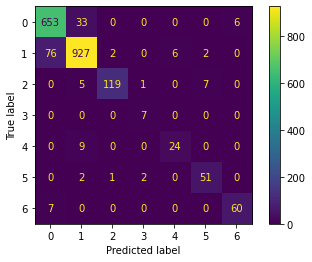

In [263]:
plt=cmdisp.plot()

In [265]:
from sklearn.metrics import top_k_accuracy_score

## Explaination

In [270]:
import google.cloud.aiplatform
XAI = "ig"  # [ shapley, ig, xrai ]

if XAI == "shapley":
    PARAMETERS = {"sampled_shapley_attribution": {"path_count": 10}}
elif XAI == "ig":
    PARAMETERS = {"integrated_gradients_attribution": {"step_count": 50}}
elif XAI == "xrai":
    PARAMETERS = {"xrai_attribution": {"step_count": 50}}

parameters = aiplatform.explain.ExplanationParameters(PARAMETERS)

In [272]:
import tensorflow as tf
model_path_to_deploy="gs://level300/aiplatform-custom-training-2022-03-24-09:16:42.507/model"
loaded = tf.saved_model.load(model_path_to_deploy)

In [274]:
serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)
serving_output = list(loaded.signatures["serving_default"].structured_outputs.keys())[0]
print("Serving function output:", serving_output)



Serving function input: dense_input
Serving function output: dense_3


In [276]:
loaded.signatures["serving_default"].structured_input_signature

((),
 {'dense_input': TensorSpec(shape=(None, 54), dtype=tf.float32, name='dense_input')})

In [278]:
list(area_cover_dataframe.columns)
FILE_NAME = "model/updated_test.csv"
df = pd.read_csv(FILE_NAME)

In [ ]:
list(df.columns)

In [283]:
INPUT_METADATA = {
    "input_tensor_name": serving_input,
    "encoding": "BAG_OF_FEATURES",
    "modality": "numeric",
    "index_feature_mapping": [
        'Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'C2702',
 'C2703',
 'C2704',
 'C2705',
 'C2706',
 'C2717',
 'C3501',
 'C3502',
 'C4201',
 'C4703',
 'C4704',
 'C4744',
 'C4758',
 'C5101',
 'C5151',
 'C6101',
 'C6102',
 'C6731',
 'C7101',
 'C7102',
 'C7103',
 'C7201',
 'C7202',
 'C7700',
 'C7701',
 'C7702',
 'C7709',
 'C7710',
 'C7745',
 'C7746',
 'C7755',
 'C7756',
 'C7757',
 'C7790',
 'C8703',
 'C8707',
 'C8708',
 'C8771',
 'C8772',
 'C8776',
 'Cache',
 'Commanche',
 'Neota',
 'Rawah',
    ],
}

OUTPUT_METADATA = {"output_tensor_name": serving_output}

input_metadata = aiplatform.explain.ExplanationMetadata.InputMetadata(INPUT_METADATA)
output_metadata = aiplatform.explain.ExplanationMetadata.OutputMetadata(OUTPUT_METADATA)

metadata = aiplatform.explain.ExplanationMetadata(
    inputs={"features": input_metadata}, outputs={"medv": output_metadata}
)

In [284]:
model = aiplatform.Model.upload(
    display_name="area-copverage-vertex-ai-pipeline-training-model" + TIMESTAMP,
    artifact_uri=model_path_to_deploy,
    serving_container_image_uri=DEPLOY_IMAGE,
    explanation_parameters=parameters,
    explanation_metadata=metadata,
    sync=False,
)


INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/313681173937/locations/us-central1/models/2652360695777067008/operations/8413043580775432192


In [285]:
model.wait()

INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/313681173937/locations/us-central1/models/2652360695777067008
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/313681173937/locations/us-central1/models/2652360695777067008')


In [291]:
DEPLOYED_NAME="area-copverage-vertex-ai-pipeline-training-model" + TIMESTAMP

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1
DEPLOY_GPU="NVIDIA_TESLA_T4"
if DEPLOY_GPU:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU,
        accelerator_count=1,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )
else:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU,
        accelerator_count=1,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/313681173937/locations/us-central1/endpoints/1345916581607112704/operations/465316138373349376
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/313681173937/locations/us-central1/endpoints/1345916581607112704
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/313681173937/locations/us-central1/endpoints/1345916581607112704')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/313681173937/locations/us-central1/endpoints/1345916581607112704
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/313681173937/locations/us-central1/endpoints/1345916581607112704/operations/5734527702396829696
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/313681173937

In [292]:
def get_instances(file_name):
    instances = []
    test_df = pd.read_csv(file_name)
    print(test_df.shape)
    test_df= test_df.iloc[: , 1:]
    standard_scaler = StandardScaler()
    scaled_features = standard_scaler.fit_transform(test_df)
    for row in scaled_features:
        instances.append(list(row))
    return instances


def get_instances_from_arr(arr):
    instances = []
    for row in arr:
        instances.append(list(row))
    return instances

instances = get_instances_from_arr(dfx_val[:1])
#instances_list = [test_item.tolist()]

prediction = endpoint.explain(instances)
print(prediction)

Prediction(predictions=[[0.128417, 0.838616, 0.000395665, 3.23726955e-19, 0.0322826281, 0.000264784787, 2.38907978e-05]], deployed_model_id='4832036944726720512', explanations=[attributions {
  baseline_output_value: 0.6634126901626587
  instance_output_value: 0.8386160135269165
  feature_attributions {
    struct_value {
      fields {
        key: "Aspect"
        value {
          list_value {
            values {
              number_value: -0.042764563113451
            }
          }
        }
      }
      fields {
        key: "C2702"
        value {
          list_value {
            values {
              number_value: 0.01719162613153458
            }
          }
        }
      }
      fields {
        key: "C2703"
        value {
          list_value {
            values {
              number_value: 0.02272014133632183
            }
          }
        }
      }
      fields {
        key: "C2704"
        value {
          list_value {
            values {
              nu

In [293]:
value = prediction[0][0][0]
print("Predicted Value:", value)

Predicted Value: 0.128417


In [296]:
attributions = prediction.explanations[0].attributions[0].feature_attributions

In [298]:
attributions["Elevation"]

[-0.05113434791564941]

In [303]:
from tabulate import tabulate

feature_names = [
    'Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'C2702',
 'C2703',
 'C2704',
 'C2705',
 'C2706',
 'C2717',
 'C3501',
 'C3502',
 'C4201',
 'C4703',
 'C4704',
 'C4744',
 'C4758',
 'C5101',
 'C5151',
 'C6101',
 'C6102',
 'C6731',
 'C7101',
 'C7102',
 'C7103',
 'C7201',
 'C7202',
 'C7700',
 'C7701',
 'C7702',
 'C7709',
 'C7710',
 'C7745',
 'C7746',
 'C7755',
 'C7756',
 'C7757',
 'C7790',
 'C8703',
 'C8707',
 'C8708',
 'C8771',
 'C8772',
 'C8776',
 'Cache',
 'Commanche',
 'Neota',
 'Rawah'
]
attributions = prediction.explanations[0].attributions[0].feature_attributions

rows = []
for i, val in enumerate(feature_names):
    rows.append([val, dfx_val[0][i], attributions[val]])
print(tabulate(rows, headers=["Feature name", "Scaled Feature value", "Attribution value"]))

Feature name                          Scaled Feature value  Attribution value
----------------------------------  ----------------------  ------------------------
Elevation                                      -0.261124    [-0.05113434791564941]
Aspect                                          1.3372      [-0.042764563113451]
Slope                                          -0.814243    [-0.01872320100665092]
Horizontal_Distance_To_Hydrology               -0.55921     [0.04101450741291046]
Vertical_Distance_To_Hydrology                 -0.488448    [0.0126778706908226]
Horizontal_Distance_To_Roadways                -0.304428    [0.1057233512401581]
Hillshade_9am                                  -0.492677    [-0.01008445210754871]
Hillshade_Noon                                  0.64225     [0.01982821524143219]
Hillshade_3pm                                   0.877936    [-0.04648313671350479]
Horizontal_Distance_To_Fire_Points             -0.630152    [0.2414994537830353]
C2702            

In [330]:
flist = list(feature_names)
alist=[]
for feature in feature_names:
    alist.append(attributions[feature][0])

<AxesSubplot:>

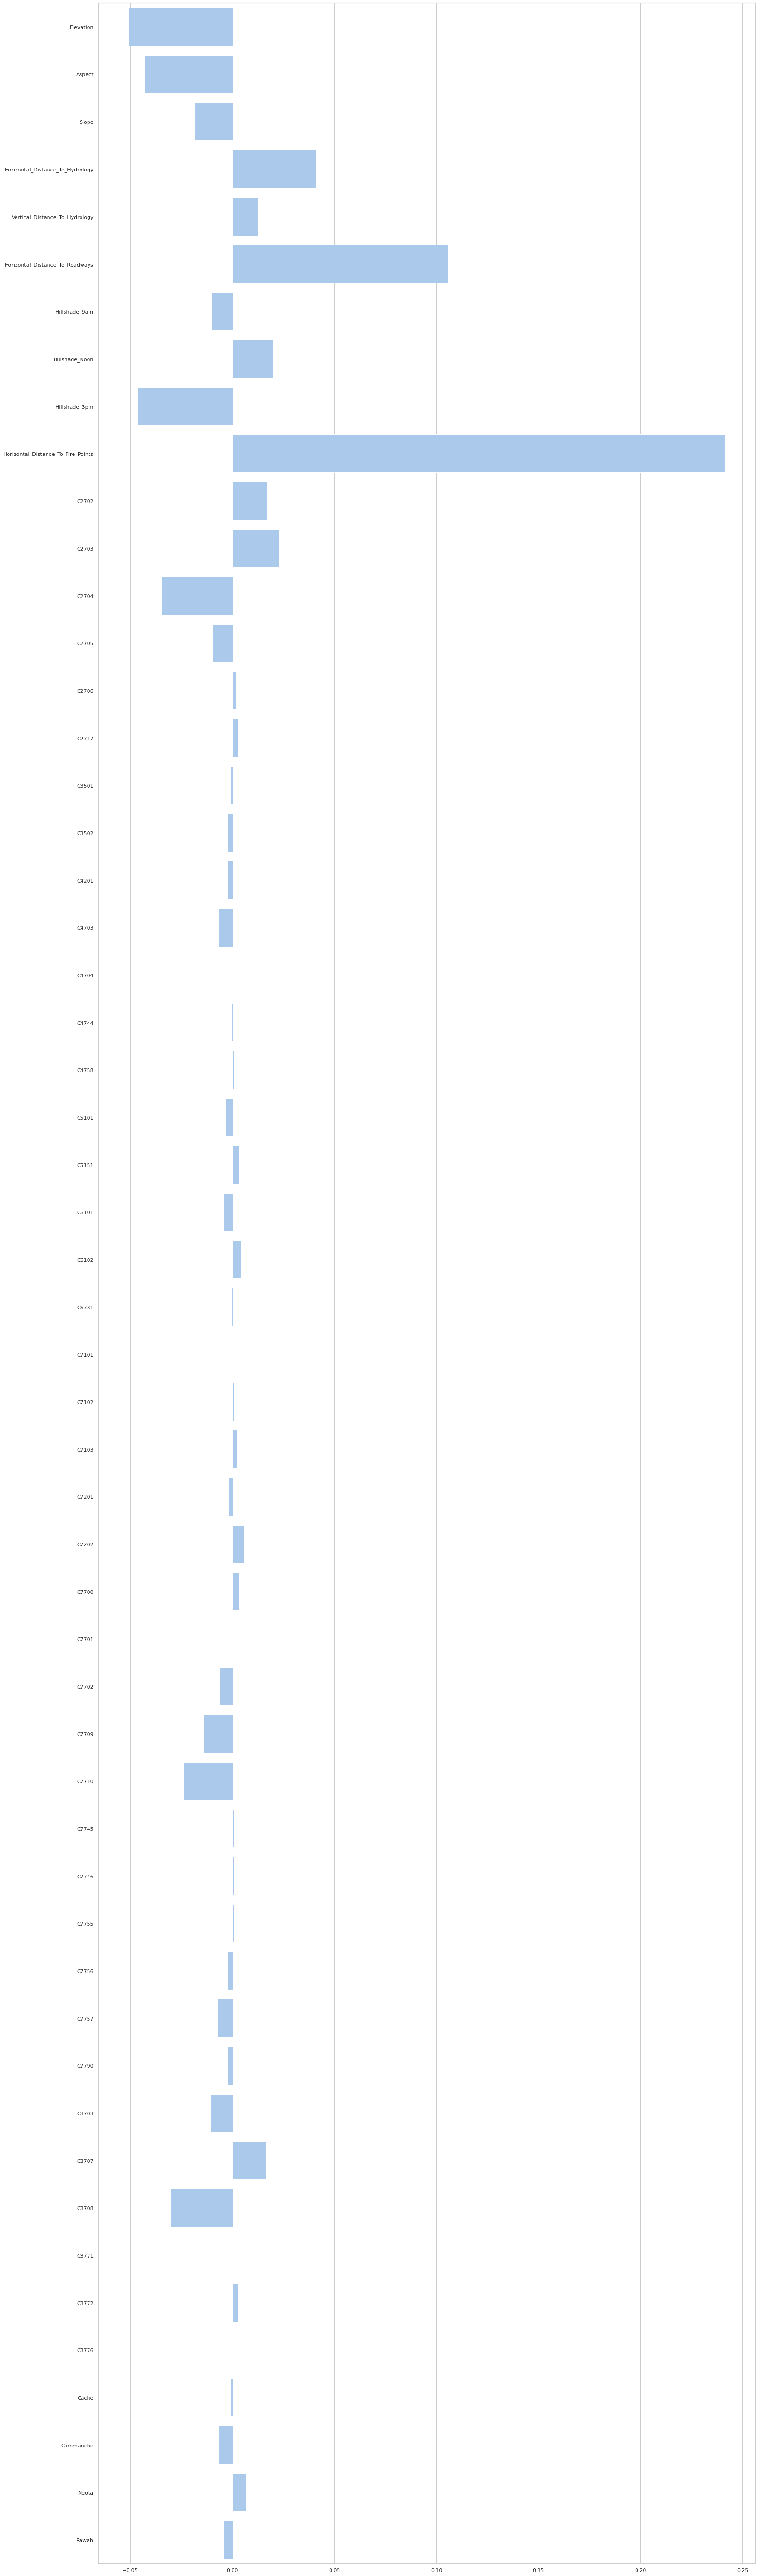

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(25, 100))
sns.set_color_codes("pastel")
sns.barplot(y=flist, x=alist,
            label="Total", color="b",orient = 'h')


In [341]:
endpoint.undeploy_all()

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/313681173937/locations/us-central1/endpoints/1345916581607112704
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/313681173937/locations/us-central1/endpoints/1345916581607112704/operations/9159515219012091904
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/313681173937/locations/us-central1/endpoints/1345916581607112704


resource name: projects/313681173937/locations/us-central1/endpoints/1345916581607112704